In [1]:
import os

In [2]:
%pwd

'c:\\Users\\manob\\Documents\\Kidney_Disease_Detection\\Kidney_Disease_Detection\\Pretrained Models\\ResNet50V2'

In [3]:
os.chdir("../")
os.chdir("../")

In [4]:
%pwd

'c:\\Users\\manob\\Documents\\Kidney_Disease_Detection\\Kidney_Disease_Detection'

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

c:\Users\manob\Documents\Kidney_Disease_Detection\Kidney_Disease_Detection\.conda\Lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\manob\Documents\Kidney_Disease_Detection\Kidney_Disease_Detection\.conda\Lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\manob\Documents\Kidney_Disease_Detection\Kidney_Disease_Detection\.conda\Lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [6]:
# Configuration
BASE_DIR = "artifacts/data_ingestion/Combined_Training_Data"  # Directory containing Stone and Non-Stone folders
MODEL_PATH = "Pretrained Models/ResNet50V2/resnet50v2_kidney_stone_model.h5"  # Path to the model we just created
SAVE_BEST_MODEL_PATH = "Pretrained Models/ResNet50V2/resnet50v2_kidney_stone_model_trained.h5"  # Path to save the trained model

# Hyperparameters
IMAGE_SIZE = (299, 299)  # Match with the model's input size
BATCH_SIZE = 16  # Smaller batch size for better generalization
EPOCHS = 40  # More epochs for better convergence

In [7]:
# Check class balance to determine class weights
stone_dir = os.path.join(BASE_DIR, 'Stone')
non_stone_dir = os.path.join(BASE_DIR, 'Non-Stone')
stone_count = len(os.listdir(stone_dir))
non_stone_count = len(os.listdir(non_stone_dir))
total_count = stone_count + non_stone_count

print(f"Stone images: {stone_count} ({stone_count/total_count:.2%})")
print(f"Non-Stone images: {non_stone_count} ({non_stone_count/total_count:.2%})")

# Calculate class weights to handle imbalance
weight_for_0 = (1 / non_stone_count) * (total_count / 2.0)  # For Non-Stone class
weight_for_1 = (1 / stone_count) * (total_count / 2.0)  # For Stone class

class_weight = {0: weight_for_0, 1: weight_for_1}
print(f"Class weights: {class_weight}")

Stone images: 18194 (46.87%)
Non-Stone images: 20627 (53.13%)
Class weights: {0: 0.9410239007126582, 1: 1.066862701989667}


In [8]:
# Create enhanced image generators with validation split
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,  # Add horizontal shift
    height_shift_range=0.1,  # Add vertical shift
    brightness_range=[0.9, 1.1],  # Add brightness variation
    fill_mode='constant',  # Use constant values (black) for padding
    cval=0  # Black padding
)

# Training generator
train_generator = datagen.flow_from_directory(
    BASE_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle=True
)

# Validation generator
val_generator = datagen.flow_from_directory(
    BASE_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False  # Don't shuffle validation data for consistent evaluation
)

Found 31058 images belonging to 2 classes.
Found 7763 images belonging to 2 classes.


In [ ]:
# Load pre-built model
model = load_model(MODEL_PATH)

# Display model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 305, 305, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 150, 150, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
# Unfreeze some layers for fine-tuning
# First, print the model structure to understand it better
print("Model layers:")
for i, layer in enumerate(model.layers):
    print(f"Layer {i}: {layer.name}, type: {type(layer).__name__}")

# Get the base model
try:
    # First try to find a layer with 'resnet' in the name
    base_model = None
    for layer in model.layers:
        if 'resnet' in layer.name.lower():
            base_model = layer
            print(f"Found ResNet layer: {layer.name}")
            break
    
    # If not found, use the first layer as a fallback
    if base_model is None:
        base_model = model.layers[0]
        print(f"Using first layer as base model: {type(base_model).__name__}")
except Exception as e:
    print(f"Error finding base model: {e}")
    print("Using the entire model as the base model")
    base_model = model

# Make the base model trainable
base_model.trainable = True

# Get total number of layers in the base model
try:
    total_layers = len(base_model.layers)
    print(f"Total layers in base model: {total_layers}")
except AttributeError:
    print("Base model doesn't have layers attribute. Using a different approach.")
    # If the base model doesn't have layers, we'll use a simpler approach
    total_layers = 0
    base_model.trainable = True

# Freeze all layers except the last 20
try:
    if total_layers > 0:
        for i, layer in enumerate(base_model.layers):
            if i < total_layers - 20:
                layer.trainable = False
            else:
                layer.trainable = True
        
        # Count trainable layers
        trainable_count = sum(1 for layer in base_model.layers if layer.trainable)
        print(f"Trainable layers in base model: {trainable_count}")
    else:
        print("Using the entire model as trainable")
except Exception as e:
    print(f"Error while setting trainable layers: {e}")
    print("Continuing with default trainable settings")

Model layers:
Layer 0: input_1, type: InputLayer
Layer 1: conv1_pad, type: ZeroPadding2D
Layer 2: conv1_conv, type: Conv2D
Layer 3: pool1_pad, type: ZeroPadding2D
Layer 4: pool1_pool, type: MaxPooling2D
Layer 5: conv2_block1_preact_bn, type: BatchNormalization
Layer 6: conv2_block1_preact_relu, type: Activation
Layer 7: conv2_block1_1_conv, type: Conv2D
Layer 8: conv2_block1_1_bn, type: BatchNormalization
Layer 9: conv2_block1_1_relu, type: Activation
Layer 10: conv2_block1_2_pad, type: ZeroPadding2D
Layer 11: conv2_block1_2_conv, type: Conv2D
Layer 12: conv2_block1_2_bn, type: BatchNormalization
Layer 13: conv2_block1_2_relu, type: Activation
Layer 14: conv2_block1_0_conv, type: Conv2D
Layer 15: conv2_block1_3_conv, type: Conv2D
Layer 16: conv2_block1_out, type: Add
Layer 17: conv2_block2_preact_bn, type: BatchNormalization
Layer 18: conv2_block2_preact_relu, type: Activation
Layer 19: conv2_block2_1_conv, type: Conv2D
Layer 20: conv2_block2_1_bn, type: BatchNormalization
Layer 21: co

In [11]:
# Recompile the model with a lower learning rate for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Lower learning rate for fine-tuning
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

In [12]:
# Enhanced callbacks
# 1. Model checkpoint - save the best model
checkpoint_cb = ModelCheckpoint(
    SAVE_BEST_MODEL_PATH, 
    save_best_only=True, 
    monitor='val_auc', 
    mode='max',  # We want to maximize AUC
    verbose=1
)

# 2. Early stopping - prevent overfitting
earlystop_cb = EarlyStopping(
    monitor='val_auc', 
    patience=8,  # More patience for fine-tuning
    restore_best_weights=True, 
    mode='max',  # We want to maximize AUC
    verbose=1
)

# 3. Learning rate reduction on plateau
reduce_lr_cb = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,  # Reduce learning rate by half when plateau is detected
    patience=3,  # Wait for 3 epochs before reducing
    min_lr=1e-7,  # Minimum learning rate
    verbose=1  # Print when learning rate is reduced
)

In [13]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[checkpoint_cb, earlystop_cb, reduce_lr_cb],
    class_weight=class_weight,  # Use calculated class weights
    workers=2,  # Reduced parallel data loading to avoid issues
    use_multiprocessing=False,  # Disable multiprocessing to avoid issues
    verbose=1
)

Epoch 1/40
1942/1942 [==============================] - ETA: 0s - loss: 0.8983 - accuracy: 0.5366 - auc: 0.5484 - precision: 0.5053 - recall: 0.5337
Epoch 1: val_auc improved from -inf to 0.50132, saving model to Pretrained Models/ResNet50V2\resnet50v2_kidney_stone_model_trained.h5
1942/1942 [==============================] - 2177s 1s/step - loss: 0.8983 - accuracy: 0.5366 - auc: 0.5484 - precision: 0.5053 - recall: 0.5337 - val_loss: 0.7829 - val_accuracy: 0.4804 - val_auc: 0.5013 - val_precision: 0.4246 - val_recall: 0.3065 - lr: 1.0000e-05
Epoch 2/40
1942/1942 [==============================] - ETA: 0s - loss: 0.8172 - accuracy: 0.5676 - auc: 0.5940 - precision: 0.5368 - recall: 0.5637
Epoch 2: val_auc improved from 0.50132 to 0.51963, saving model to Pretrained Models/ResNet50V2\resnet50v2_kidney_stone_model_trained.h5
1942/1942 [==============================] - 2222s 1s/step - loss: 0.8172 - accuracy: 0.5676 - auc: 0.5940 - precision: 0.5368 - recall: 0.5637 - val_loss: 0.7944 - 

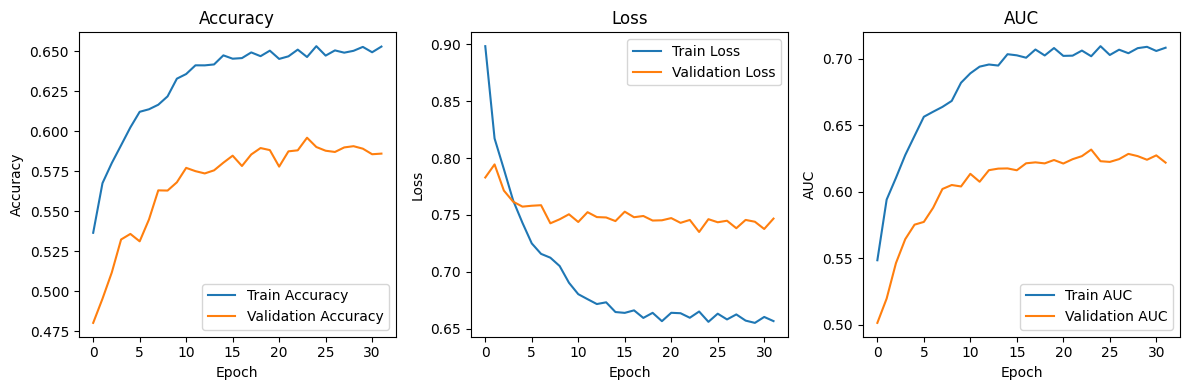

In [14]:
# Plot training history
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot AUC
plt.subplot(1, 3, 3)
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.title('AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()

plt.tight_layout()
plt.show()

In [15]:
# Create directory for plots
PLOTS_DIR = "Pretrained Models/ResNet50V2/training_plots"
os.makedirs(PLOTS_DIR, exist_ok=True)

# Save the training history for later analysis
import json
with open(f"{PLOTS_DIR}/training_history.json", 'w') as f:
    # Convert numpy values to Python native types for JSON serialization
    history_dict = {k: [float(val) for val in v] for k, v in history.history.items()}
    json.dump(history_dict, f)

print(f"Training completed. Best model saved at: {SAVE_BEST_MODEL_PATH}")

Training completed. Best model saved at: Pretrained Models/ResNet50V2/resnet50v2_kidney_stone_model_trained.h5
